<a href="https://colab.research.google.com/github/CzSadykov/optimal_oil_location/blob/main/EN_optimal_oil_well_location_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting an optimal oil well location

**Problem situation**: On assignment for a fictitious mining company we help to decide where to drill a new oil well.

**Goal**: to determine the most profitable region for the development of oil wells.

**Tasks**:

1. Build a machine learning model that will help determine the region where mining will bring the most profit.
2. Analyze possible profits and risks using the *Bootstrap* technique

**Data**:

The data is taken from the exploration of three regions, each dataset contains 100,000 observations.
List of variables:

* ```id``` — unique identifier of the well;
* ```f0, f1, f2``` - well characteristics;
* **```product```** — volume of reserves in the well (in thousands of barrels). That's our target variable.

## Importing libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier
from numpy.random import randint

from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    mean_absolute_error
)

## Data loading and preprocessing

Let's load the data and evaluate it for gaps and data types.

In [5]:
df_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
df_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
df_3 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

In [6]:
print(df_1.info(), '\n')
print(df_2.info(), '\n')
print(df_3.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Colu

There are no gaps, but there is an explicit nominal variable ```id```, which will not be useful in our study.

We will remove it. Later.

In [7]:
df_2.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


Let's check the number of duplicates for each region.

In [8]:
print(df_1.duplicated().sum())
print(df_2.duplicated().sum())
print(df_3.duplicated().sum())

0
0
0


They don't, great. Are the well ids duplicated, or each one is unique?

In [9]:
print(df_1['id'].duplicated().sum())
print(df_2['id'].duplicated().sum())
print(df_3['id'].duplicated().sum())

10
4
4


Yes, they are duplicated. We'll keep in mind.

Now we make histograms of features for each region in order to evaluate distributions.

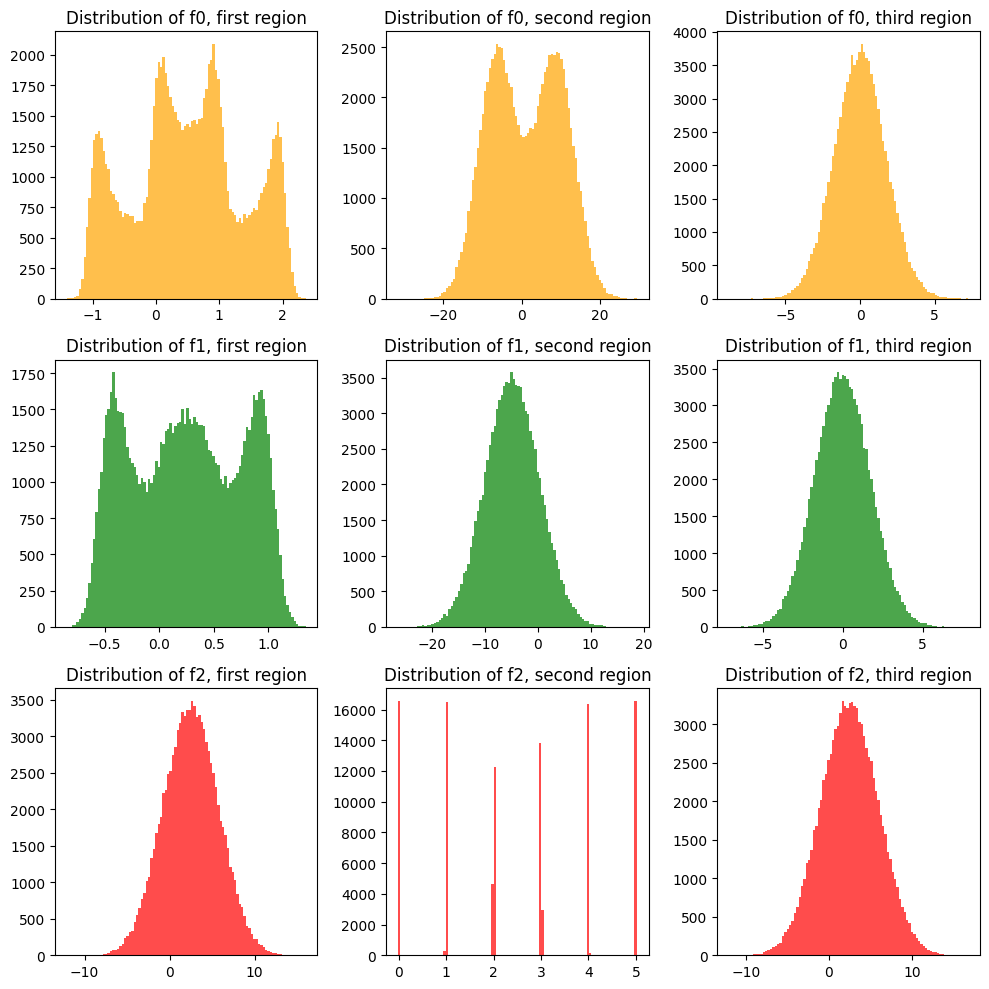

In [10]:
fig, ax = plt.subplots(3,3, figsize=(10,10))

ax[0,0].hist(df_1['f0'], bins=100, alpha=0.7, color='orange');
ax[0,0].set_title('Distribution of f0, first region');
ax[0,1].hist(df_2['f0'], bins=100, alpha=0.7, color='orange');
ax[0,1].set_title('Distribution of f0, second region');
ax[0,2].hist(df_3['f0'], bins=100, alpha=0.7, color='orange');
ax[0,2].set_title('Distribution of f0, third region');

ax[1,0].hist(df_1['f1'], bins=100, alpha=0.7, color='green');
ax[1,0].set_title('Distribution of f1, first region');
ax[1,1].hist(df_2['f1'], bins=100, alpha=0.7, color='green');
ax[1,1].set_title('Distribution of f1, second region');
ax[1,2].hist(df_3['f1'], bins=100, alpha=0.7, color='green');
ax[1,2].set_title('Distribution of f1, third region');

ax[2,0].hist(df_1['f2'], bins=100, alpha=0.7, color='red');
ax[2,0].set_title('Distribution of f2, first region');
ax[2,1].hist(df_2['f2'], bins=100, alpha=0.7, color='red');
ax[2,1].set_title('Distribution of f2, second region');
ax[2,2].hist(df_3['f2'], bins=100, alpha=0.7, color='red');
ax[2,2].set_title('Distribution of f2, third region');

plt.tight_layout()
plt.show()

In most cases, the distribution is normal, but there are some deviations from the norm. The ```f2``` feature is the most striking in the second region. Let's look at it closer.

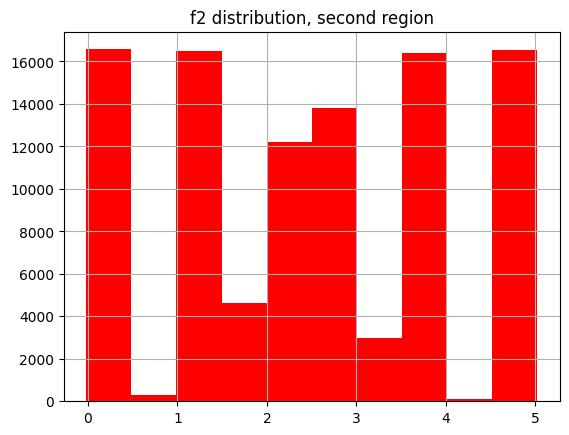

In [11]:
hist_2_2 = df_2['f2'].hist(bins=10, color='red');
hist_2_2.set_title('f2 distribution, second region');

Not knowing the specifics of the data contained in it, we cannot put forward sufficiently clear assumptions.

Let's now look at the numerical characteristics of the data.

In [12]:
display(df_1.describe())
display(df_2.describe())
display(df_3.describe())

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


There are no obvious anomalies. But let's check the features for multicollinearity.

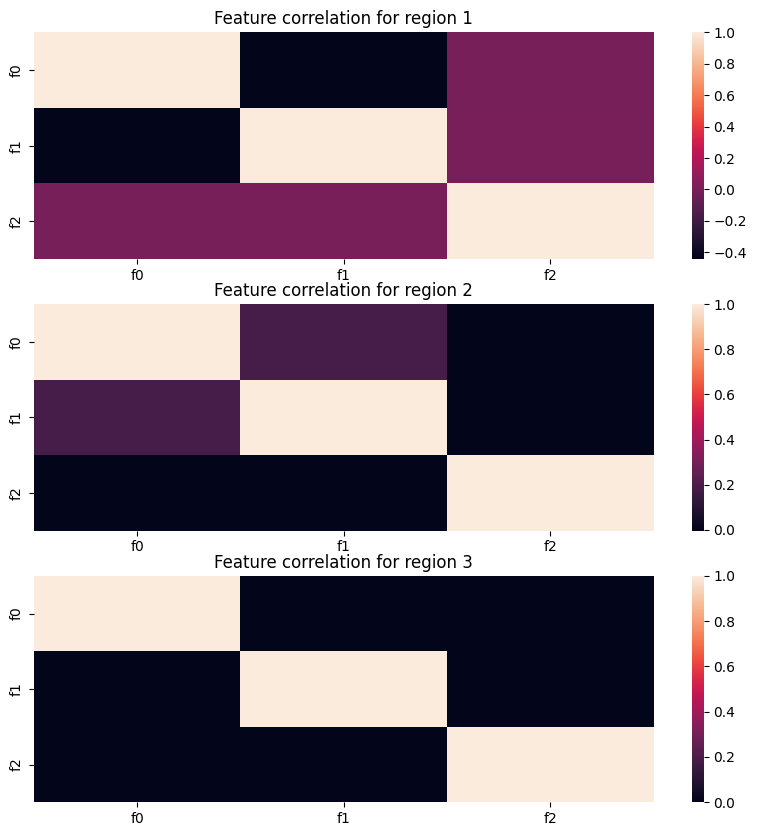

In [13]:
fig, axes = plt.subplots(3, figsize=(10,10))

sns.heatmap(df_1[['f0','f1','f2']].corr(), ax=axes[0])
sns.heatmap(df_2[['f0','f1','f2']].corr(), ax=axes[1])
sns.heatmap(df_3[['f0','f1','f2']].corr(), ax=axes[2])

axes[0].set_title('Feature correlation for region 1')
axes[1].set_title('Feature correlation for region 2')
axes[2].set_title('Feature correlation for region 3')

plt.show()

There is practically no correlation between the features, hooray.

Let's now look at the distribution of the target feature.

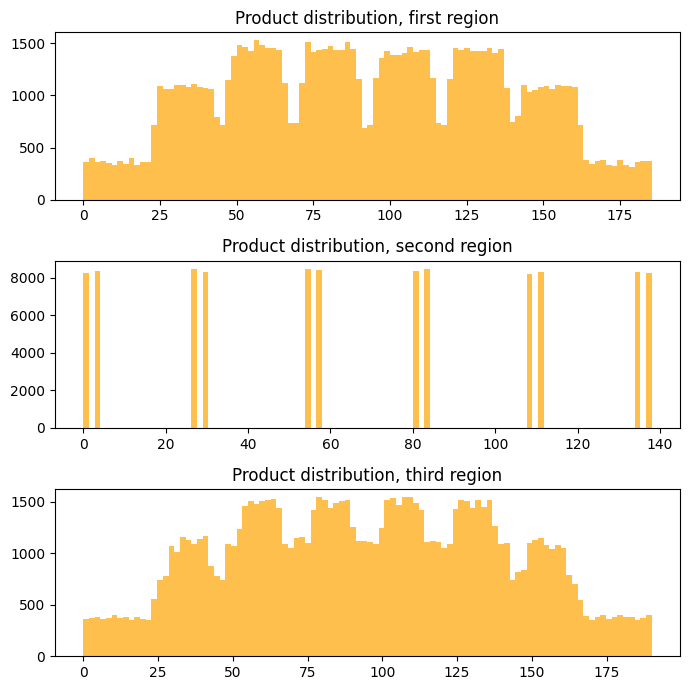

In [14]:
fig, axes = plt.subplots(3, figsize=(7,7))

axes[0].hist(df_1['product'], bins=100, alpha=0.7, color='orange');
axes[0].set_title('Product distribution, first region');
axes[1].hist(df_2['product'], bins=100, alpha=0.7, color='orange');
axes[1].set_title('Product distribution, second region');
axes[2].hist(df_3['product'], bins=100, alpha=0.7, color='orange');
axes[2].set_title('Product distribution, third region');

plt.tight_layout()
plt.show()

The distribution in the first and second regions is close to normal (there are outlines of a bell), but fluctuations are interesting - for example, declines at values of about 50, 75, 100 - that is, with a step of 25. Curious.

As for the second region, the production values in it are even more fragmented, and the distribution of the target feature resembles the distribution of the characteristic f2. Well, again, without knowing the specifics of the data, we can only guess.

Let's prepare datasets for training by highlighting the target feature.

In [15]:
dataframes = [df_1, df_2, df_3]

def process(df):
    df = df.drop(columns='id')
    target = df['product']
    features = df.drop(columns='product')
    return features, target

In [16]:
features_1, target_1 = process(df_1)
features_2, target_2 = process(df_2)
features_3, target_3 = process(df_3)

## Training and validating the model

### Region #1

Let's start with the usual linear regression (and end with it, according to initial requirements :)). First, let's split the datasets into training and validation sets.

In [17]:
RANDOM_STATE = 11235

features_1_train, features_1_valid, target_1_train, target_1_valid = train_test_split(features_1,
                                                                             target_1,
                                                                             test_size=0.25,
                                                                             random_state=RANDOM_STATE)

print(features_1_train.shape)
print(target_1_train.shape)
print(features_1_valid.shape)
print(target_1_valid.shape)

(75000, 3)
(75000,)
(25000, 3)
(25000,)


We've splitted the data correctly. Now let's train the model and calculate its MSE.

In [18]:
model_1 = LinearRegression()
model_1.fit(features_1_train, target_1_train)
rmse_1 = mean_squared_error(target_1_valid, model_1.predict(features_1_valid)) ** 0.5
print(f'RMSE for the linear regression predictions in region 1 is {rmse_1:.2f}')

RMSE for the linear regression predictions in region 1 is 37.67


Let's estimate the error by looking at the mean of the predictions.

In [19]:
print(f'Среднее значение предсказаний линейной регрессии в регионе 1 составляет \
{model_1.predict(features_1_valid).mean():.2f}')

Среднее значение предсказаний линейной регрессии в регионе 1 составляет 92.38


The error seems to be large enough, but according to the condition of the problem, for greater predictability we shall use linear regression. Welp. Let's save the predictions and look at all the key characteristics of the model at once.

In [20]:
predictions_1 = pd.Series(model_1.predict(features_1_valid), index=target_1_valid.index)
r2_1 = r2_score(target_1_valid, predictions_1)
mae_1 = mean_absolute_error(target_1_valid, predictions_1)

print(f'Mean of predictions for region 1: {predictions_1.mean():.2f}')
print(f'RMSE of the model used: {rmse_1:.2f}')
print(f'R^2: {r2_1:.2f}')
print(f'MAE: {mae_1:.2f}')

Mean of predictions for region 1: 92.38
RMSE of the model used: 37.67
R^2: 0.28
MAE: 31.02


The quality is far from perfect, but let's repeat the procedure for other regions.

### Region 2

In [21]:
features_2_train, features_2_valid, target_2_train, target_2_valid = train_test_split(features_2,
                                                                             target_2,
                                                                             test_size=0.25,
                                                                             random_state=RANDOM_STATE)

In [22]:
model_2 = LinearRegression()
model_2.fit(features_2_train, target_2_train)
rmse_2 = mean_squared_error(target_2_valid, model_2.predict(features_2_valid)) ** 0.5
print(f'RMSE for region 2: {rmse_2:.2f}')

RMSE for region 2: 0.89


Suspiciously small deviation, let's evaluate all the characteristics.

In [23]:
predictions_2 = pd.Series(model_2.predict(features_2_valid), index=target_2_valid.index)
r2_2 = r2_score(target_2_valid, predictions_2)
mae_2 = mean_absolute_error(target_2_valid, predictions_2)

print(f'Mean of predictions for region 2: {predictions_2.mean():.2f}')
print(f'RMSE: {rmse_2:.2f}')
print(f'R2: {r2_2:.5f}')
print(f'MAE: {mae_2:.2f}')

Mean of predictions for region 2: 68.54
RMSE: 0.89
R2: 0.99962
MAE: 0.72


Surprisingly low deviations (rmse and mae) and high coefficient of determination. Okay, let's not complain about perfection.

### Регион 3

In [24]:
features_3_train, features_3_valid, target_3_train, target_3_valid = train_test_split(features_3,
                                                                             target_3,
                                                                             test_size=0.25,
                                                                             random_state=RANDOM_STATE)

In [25]:
model_3 = LinearRegression()
model_3.fit(features_3_train, target_3_train)
rmse_3 = mean_squared_error(target_3_valid, model_3.predict(features_3_valid)) ** 0.5
print(f'RMSE in region 3: {rmse_3:.2f}')

RMSE in region 3: 40.00


Almost like in the first region. Let's save the predictions and evaluate all the characteristics.

In [26]:
predictions_3 = pd.Series(model_3.predict(features_3_valid), index=target_3_valid.index)
r2_3 = r2_score(target_3_valid, predictions_3)
mae_3 = mean_absolute_error(target_3_valid, predictions_3)

print(f'Mean of predictions for region 3: {predictions_3.mean():.2f}')
print(f'RMSE: {rmse_3:.2f}')
print(f'R^2: {r2_3:.2f}')
print(f'MAE: {mae_3:.2f}')

Mean of predictions for region 3: 94.92
RMSE: 40.00
R^2: 0.20
MAE: 32.71


The coefficient of determination is 0.2. It's tempting to try other models, but let's stay within the requirements' frame.

### Comparing the metrics

Now let's visualize the difference in indicators for clarity.

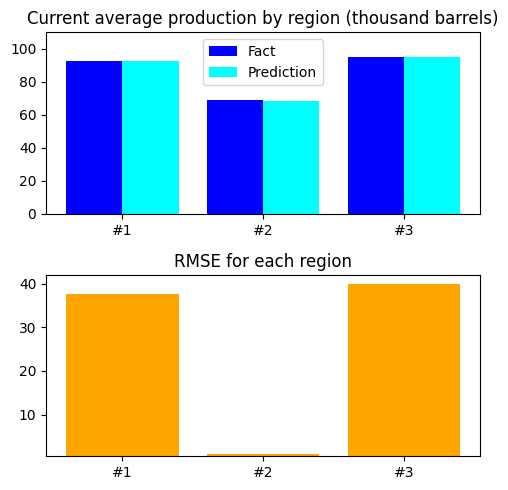

In [34]:
fig, ax = plt.subplots(2,1, figsize=(5,5));

region_bars = ['#1', '#2', '#3']
region_height = [target_1.mean(), target_2.mean(), target_3.mean()]
prediction_height = [predictions_1.mean(), predictions_2.mean(), predictions_3.mean()]

width = 0.4
ind = np.arange(len(region_bars))

ax[0].bar(ind - width/2, region_height, width, color='blue', label='Fact');
ax[0].bar(ind + width/2, prediction_height, width, color='cyan', label='Prediction');
ax[0].set_title('Current average production by region (thousand barrels)');
ax[0].set_ylim(0,110);
ax[0].set_xticks(ind)
ax[0].set_xticklabels(region_bars)
ax[0].legend()

rmse_bars = ['#1', '#2', '#3']
rmse_height = [rmse_1, rmse_2, rmse_3]
ax[1].bar(rmse_bars, rmse_height, color='orange');
ax[1].set_title('RMSE for each region');
ax[1].set_ylim(0.45);

plt.tight_layout()

plt.show();

The average values of the predictions are practically the same as the averages of the actual data.

It is striking how much better the models work for region No. 2. But since the specifics of the data are unknown to us, we cannot yet make meaningful assumptions.

To be sure, let's quantify the difference between the averages in the actual data and predictions.

In [28]:
print(region_height)
print(prediction_height)

[92.50000000000001, 68.82500000000002, 95.00000000000004]
[92.38496873374059, 68.53753761594476, 94.92033651991625]


Yep, it's miniscule.

## Calculating the profit

Let's write down the main constants that will be useful for our calculations.

In [29]:
BUDGET_RUB = 10_000_000_000
UNIT = 1000
UNIT_REVENUE = 450
THRESHOLD = 200
LOSSLESS_PROD_MARGIN = BUDGET_RUB / (UNIT * UNIT_REVENUE) / THRESHOLD

print(f'{LOSSLESS_PROD_MARGIN:.2f} \n')

111.11 



* ```budget_rub``` - the budget for the development of wells in each region (10,000,000,000 rubles).
* ```unit``` is a unit of measurement of the target attribute (1 thousand barrels).
* ```unit_revenue``` - revenue from one barrel (450 rubles).
* ```lossless_production_margin ``` is the number of barrels to reach the breakeven threshold in the region (22,222,222 barrels).

Let's estimate how many fields need to be developed in each region to reach the breakeven threshold. And for evaluation we take the average value of our predictions for each region.

In [30]:
for i in prediction_height:
    print(f'{LOSSLESS_PROD_MARGIN/i:.3f}', '\n')

1.203 

1.621 

1.171 



Based on the predicted average production values, it will be enough to develop **two** fields in each region (provided that their performance will correspond to our predicted average)...

But in order to reduce risks to zero and highlight the most profitable wells, we will make a function for calculating profit.

In [31]:
def estimate_profit(target, predictions, count):
    sources = pd.Series(predictions).sort_values(ascending=False)
    selected_sources = target[sources.index][:count]
    sum_revenue = selected_sources.sum() * UNIT * UNIT_REVENUE
    return sum_revenue - BUDGET_RUB

Now we will make a function based on the Bootstrap method to select the 200 most profitable deposits based on 1000 random subsamples of 500 observations.

By selecting the top 200 deposits 1000 times, we calculate 1000 possible profits. And write them down in a separate list.

For these returns, we will calculate the mean and confidence interval at the 95% confidence level.

We will also calculate the probability of unprofitability of deposits - it is important for the customer that it be **no more than 2.5%**.

In [32]:
def bootstrap_sources(target, predictions, region):
     values = []
     state = np.random.RandomState(RANDOM_STATE)
     for i in range(1000):
         target_subsample = target.sample(n=500, replace=True, random_state=state)
         predictions_subsample = predictions[target_subsample.index]
         values.append(estimate_profit(target_subsample, predictions_subsample, THRESHOLD))

     values = pd.Series(values)
     mean = values.mean()
     lower = values.quantile(0.025)
     upper = values.quantile(0.975)
     loss_probability = (values[values<0].count())/len(values)

     return print(f'The predicted average profit for the region {region} is {mean:,.2f} rubles. \n\
95% confidence interval: from {lower:,.2f} to {upper:,.2f} rubles. \n\
Probability of losses: {loss_probability:.2%}.')

Let's apply this function for each region.

In [33]:
bootstrap_sources(target_1_valid, predictions_1, 1)
print()
bootstrap_sources(target_2_valid, predictions_2, 2)
print()
bootstrap_sources(target_3_valid, predictions_3, 3)

The predicted average profit for the region 1 is 435,996,589.20 rubles. 
95% confidence interval: from -48,391,147.29 to 944,401,611.52 rubles. 
Probability of losses: 4.60%.

The predicted average profit for the region 2 is 477,052,539.63 rubles. 
95% confidence interval: from 74,463,435.37 to 888,676,356.26 rubles. 
Probability of losses: 1.00%.

The predicted average profit for the region 3 is 375,005,031.18 rubles. 
95% confidence interval: from -196,572,758.78 to 931,375,110.82 rubles. 
Probability of losses: 9.50%.


The probabilities of loss in regions #1 and #3 are too high! This leaves region #2 – fortunately, the average profit predicted in it is still the largest relative to the three regions.

## Conclusions

Based on the results of the analysis, we can recommend region 2 for field development. Reasons for that are:

* Probability of loss is **1%**;
* Projected average profit - **477,052,540** rubles;
* With a 95% probability, the average profit will be in the range from **74,463,435** to **888,676,356** rubles.

The model used is linear regression. Moreover, for the second region, the model turned out to be of the highest quality. Apparently, due to the specifics of the input data. Our final metrics:

* Standard deviation - 0.89
* R^2 - 0.99962
* Mean absolute deviation - 0.72